In [1]:
# import libraries
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

In [2]:
# load the dataset and apply column names
col_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
         'race','gender','capital-gain','capital-loss','hours-per-week','native-country','income']
categorical = ['workclass','education','marital-status','occupation','relationship','gender','native-country','race','income']
to_keep = ['age','workclass','education','marital-status','occupation','race','gender','native-country','income'] # columns used in the paper
categorical_to_keep = [x for x in categorical if x in to_keep]
df = pd.read_csv("adult.all.txt", sep=",", header=None, names=col_names, index_col=False, engine='python')
len(df)

48842

In [3]:
# put column names in a dict for span computing using indices
zip_iterator = zip([x for x in range(9)], to_keep)
col_dict = dict(zip_iterator)

In [4]:
cat_dict = {k: v for k, v in col_dict.items() if v in categorical_to_keep}
cat_indices = [k for k, v in cat_dict.items()]

In [5]:
# remove NaNs
df = df.loc[:,to_keep]
df = df[df!='-1'] # -1 is nan
df.dropna(inplace=True)
df.reset_index(inplace=True)
df = df.iloc[:,1:]
#df = df[:30]
df

,age,workclass,education,marital-status,occupation,race,gender,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,United-States,<=50k
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,United-States,<=50k
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,United-States,<=50k
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,United-States,<=50k
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,Cuba,<=50k
...,...,...,...,...,...,...,...,...,...
45217,33,Private,Bachelors,Never-married,Prof-specialty,White,Male,United-States,<=50k
45218,39,Private,Bachelors,Divorced,Prof-specialty,White,Female,United-States,<=50k
45219,38,Private,Bachelors,Married-civ-spouse,Prof-specialty,White,Male,United-States,<=50k
45220,44,Private,Bachelors,Divorced,Adm-clerical,Asian-Pac-Islander,Male,United-States,<=50k


In [6]:
# convert df to numpy array
m = df.groupby(df.columns.tolist(),as_index=False).size()['size'].max()
df = np.array(df)

In [7]:
# function to compute the span of a given column while restricted to a subset of rows (a data partition)
def colSpans(df, dimensions, cat_dict, partition):
  categorical = [k for k, v in cat_dict.items() if k in dimensions] # indices of categorical columns
  spans = dict()
  for column in dimensions:
    dfp = df[partition,column] # restrict df to the current column
    if column in categorical:
      span = len(np.unique(dfp)) # span of categorical variables is its number of unique classes
    else:
      span = np.max(dfp)-np.min(dfp) # span of numerical variables is its range
    spans[column] = span
  return spans

In [8]:
# function to split rows of a partition based on median value (categorical vs. numerical attributes)
def splitVal(df, dim, part, cat_dict, mode):
  dfp = df[part,dim] # restrict whole dataset to a single attribute and rows in this partition
  unique = list(np.unique(dfp))
  length = len(unique)
  categorical = [k for k, v in cat_dict.items()] # indices of categorical columns
  if dim in categorical: # for categorical variables
    #print('categorical')
    if mode=='strict': # i do not mind about |lhs| and |rhs| being equal
      lhv = unique[:length//2]
      rhv = unique[length//2:]
      lhs_v = list(list(np.where(np.isin(dfp,lhv)))[0]) # left partition
      rhs_v = list(list(np.where(np.isin(dfp,rhv)))[0]) # right partition
      lhs = [part[i] for i in lhs_v]
      rhs = [part[i] for i in rhs_v]
    elif mode=='relaxed': # i want |lhs| = |rhs| +-1
      lhv = unique[:length//2]
      rhv = unique[length//2:]
      lhs_v = list(list(np.where(np.isin(dfp,lhv)))[0]) # left partition
      rhs_v = list(list(np.where(np.isin(dfp,rhv)))[0]) # right partition
      lhs = [part[i] for i in lhs_v]
      rhs = [part[i] for i in rhs_v]
      #print('Initial partitioning: {} {}'.format(lhs,rhs))
      diff = len(lhs)-len(rhs)
      #print(diff)
      if diff==0:
        pass
      elif diff<0:
        #print('diff {}'.format(diff))
        lhs1 = rhs[:(np.abs(diff)//2)] # move first |diff|/2 indices from rhs to lhs
        rhs = rhs[(np.abs(diff)//2):] 
        lhs = np.concatenate((lhs,lhs1))
      else:
        #print('diff {}'.format(diff))
        rhs1 = lhs[-(diff//2):]
        lhs = lhs[:-(diff//2)]
        rhs = np.concatenate((rhs,rhs1))
    else:
      lhs, rhs = splitVal(df, dim, part, 'relaxed')
    #print('Final partitioning: {} {}'.format(lhs,rhs))
  else: # for numerical variables, split based on median value (strict or relaxed)
    #print(np.median(dfp))
    median = np.median(dfp)
    if mode=='strict': # strict partitioning (do not equally split indices of median values)
      lhs_v = list(list(np.where(dfp < median))[0])
      rhs_v = list(list(np.where(dfp >= median))[0])
      lhs = [part[i] for i in lhs_v]
      rhs = [part[i] for i in rhs_v]
    elif mode=='relaxed': # exact median values are equally split between the two halves
      lhs_v = list(list(np.where(dfp < median))[0])
      rhs_v = list(list(np.where(dfp > median))[0])
      median_v = list(list(np.where(dfp == median))[0])
      lhs_p = [part[i] for i in lhs_v]
      rhs_p = [part[i] for i in rhs_v]
      median_p = [part[i] for i in median_v]
      #print(lhs_p,rhs_p,median_p)
      diff = len(lhs_p)-len(rhs_p) # i need to have |lhs| = |rhs| +- 1
      #print(diff)
      if diff<0:
        med_lhs = np.random.choice(median_p, size=np.abs(diff), replace=False) # first even up |lhs_p| and |rhs_p|
        med_to_split = [i for i in median_p if i not in med_lhs] # prepare remaining indices for equal split
        lhs_p = np.concatenate((lhs_p,med_lhs))
      else: # same but |rhs_p| needs to be levelled up to |lhs_p|
        med_rhs = np.random.choice(median_p, size=np.abs(diff), replace=False)
        med_to_split = [i for i in median_p if i not in med_rhs]
        rhs_p = np.concatenate((rhs_p,med_rhs))
      med_lhs_1 = np.random.choice(med_to_split, size=(len(med_to_split)//2), replace=False) # split remaining median indices equally between lhs and rhs
      med_rhs_1 = [i for i in med_to_split if i not in med_lhs_1]
      lhs = np.concatenate((lhs_p,med_lhs_1))
      rhs = np.concatenate((rhs_p,med_rhs_1))
    else:
      #print("Mode should be either 'strict' or 'relaxed'. Falling back to relaxed mode.")
      lhs, rhs = splitVal(df, dim, part, 'relaxed')
  return [int(x) for x in lhs], [int(x) for x in rhs]

In [9]:
# create k-anonymous equivalence classes
def partitioning(df, dimensions, k, cat_dict, mode):
    
  final_partitions = []
  working_partitions = [[x for x in range(len(df))]] # start with full dataset

  while len(working_partitions) > 0: # while there is at least one working partition left
    
    #print(len(working_partitions))
    #print('Working partitions: {}'.format(working_partitions))
    partition = working_partitions[0] # take the first in the list
    #print('Current partition {}'.format(partition))
    #print(len(partition))
    working_partitions = working_partitions[1:] # remove it from list of working partitions

    if len(partition) <= 2*k: # if it is not at least 2k long, i.e. if i cannot get any new acceptable partition pair, at least k-long each
      final_partitions.append(partition) # append it to final set of partitions
      #print(len(final_partitions))
      # and skip to the next partition
    else:
      spans = colSpans(df, dimensions, cat_dict, partition) # else, get spans of the feature columns restricted to this partition
      ordered_span_cols = sorted(spans.items(), key=lambda x:x[1], reverse=True) # sort col indices in descending order based on their span
      for dim, _ in ordered_span_cols: # select the largest first, then second largest, ...
        lhs, rhs = splitVal(df, dim, partition, cat_dict, mode) # try to split this partition
        #print(len(lhs),len(rhs))
        if len(lhs) >= k and len(rhs) >= k: # if new partitions are not too small (<k items), this partitioning is okay
            working_partitions.append(lhs) 
            working_partitions.append(rhs) # re-append both new partitions to set of working partitions for further partitioning
            #print('selected dim {}'.format(dim))
            #print('Partitions: {} {}'.format(lhs,rhs))
            break # break for loop and go to next partition, if available          
      else: # if no column could provide an allowable partitioning 
        #print('No allowable cuts, adding partition {}'.format(partition))
        final_partitions.append(partition) # add the whole partition to the list of final partitions 
        #print(len(final_partitions))

  return final_partitions

In [10]:
# build k-anonymous equivalence classes
df1 = df[:25]
k = 4
#quasi_identifiers = ['age','workclass','education','education-num','marital-status','relationship']
#quasi_identifiers = ['age','fnlwgt','education-num','hours-per-week']
#quasi_identifiers = ['age','workclass','education']
#['age','workclass','education','marital-status','occupation','race','gender','native-country','income']
quasi_identifiers_cols = ['age','workclass','education','marital-status','occupation','race','gender','native-country']
quasi_identifiers = {k: v for k, v in col_dict.items() if v in quasi_identifiers_cols}
quasi_identifiers_ix = [k for k, v in col_dict.items() if v in quasi_identifiers_cols]
sensitive_data_cols = ['income']
sensitive_data = {k: v for k, v in col_dict.items() if v in sensitive_data_cols}
sensitive_data_ix = [k for k, v in col_dict.items() if v in sensitive_data_cols]

In [11]:
equivalence_classes = partitioning(df, quasi_identifiers_ix, k, cat_dict, 'strict')
len(equivalence_classes)

5952

In [12]:
# check if all items have been kept
sum = 0
for i in range(len(equivalence_classes)):
  sum += len(equivalence_classes[i])
print(sum)

45222


In [13]:
# generate the anonymised dataset
# i want a list of rows where each row has [original index + aggregate values of all feature columns + sensitive data column]
# then i will convert it to a df
def anonymize_df(df, partitions, quasi_identifiers, sensitive_data, cat_dict, mode='range'):
  
  anon_df = []
  #print(quasi_identifiers)
  categorical = [k for k, v in cat_dict.items()]

  for ip,p in tqdm(enumerate(partitions)):
    #print(p)
    aggregate_values_for_partition = []
    partition = df[p]
    for column in quasi_identifiers:
      if column in categorical:
        #print(partition.shape,column)
        values = list(np.unique(partition[:,column]))
        #aggregate_values_for_partition.append(values) 
        aggregate_values_for_partition.append(','.join(values))
      else:
        if mode=='range':
          col_min = np.min(partition[:,column])
          col_max = np.max(partition[:,column])
          if col_min == col_max:
            aggregate_values_for_partition.append(col_min)
          else:
            aggregate_values_for_partition.append('{}-{}'.format(col_min,col_max))
        elif mode=='mean':
          aggregate_values_for_partition.append(np.mean(partition[:,column]))
    for i in range(len(p)):
      sensitive_value = df[p[i],sensitive_data][0]
      #print(sensitive_value)
      anon_df.append([int(p[i])]+aggregate_values_for_partition+[sensitive_value])
  
  df_anon = pd.DataFrame(anon_df)
  dfn1 = df_anon.sort_values(df_anon.columns[0])
  dfn1 = dfn1.iloc[:,1:]
  return np.array(dfn1)

In [14]:
# anonymise dataset
dfn = anonymize_df(df, equivalence_classes, quasi_identifiers_ix, sensitive_data_ix, cat_dict)
len(dfn),len(df)

5952it [00:01, 3815.18it/s]


(45222, 45222)

In [15]:
# compare with original dataset
df[:5]

array([[39, 'State-gov', 'Bachelors', 'Never-married', 'Adm-clerical',
        'White', 'Male', 'United-States', '<=50k'],
       [50, 'Self-emp-not-inc', 'Bachelors', 'Married-civ-spouse',
        'Exec-managerial', 'White', 'Male', 'United-States', '<=50k'],
       [38, 'Private', 'HS-grad', 'Divorced', 'Handlers-cleaners',
        'White', 'Male', 'United-States', '<=50k'],
       [53, 'Private', '11th', 'Married-civ-spouse', 'Handlers-cleaners',
        'Black', 'Male', 'United-States', '<=50k'],
       [28, 'Private', 'Bachelors', 'Married-civ-spouse',
        'Prof-specialty', 'Black', 'Female', 'Cuba', '<=50k']],
      dtype=object)

In [16]:
dfn[:5]

array([['39-40', 'Self-emp-inc,Self-emp-not-inc,State-gov',
        'Assoc-voc,Bachelors,HS-grad', 'Never-married',
        'Adm-clerical,Craft-repair,Exec-managerial', 'Black,White',
        'Male', 'United-States', '<=50k'],
       [50, 'Self-emp-not-inc', 'Bachelors',
        'Divorced,Married-civ-spouse', 'Craft-repair,Exec-managerial',
        'White', 'Male', 'United-States', '<=50k'],
       ['37-38', 'Federal-gov,Private', 'HS-grad', 'Divorced',
        'Handlers-cleaners', 'Asian-Pac-Islander,White', 'Male',
        'United-States,Vietnam', '<=50k'],
       ['52-53', 'Private', '11th', 'Divorced,Married-civ-spouse',
        'Handlers-cleaners,Machine-op-inspct', 'Black,White',
        'Female,Male', 'United-States', '<=50k'],
       ['28-31', 'Private', 'Assoc-voc,Bachelors,Doctorate',
        'Divorced,Married-civ-spouse',
        'Other-service,Prof-specialty,Sales,Tech-support',
        'Asian-Pac-Islander,Black,White', 'Female,Male',
        'Cambodia,Canada,China,Columbia

In [17]:
# evaluation metrics
def discernability(partitions):
  sum = 0.0
  for p in range(len(partitions)):
    sum += len(partitions[p])**2
  return sum

def avg_eqclass(total_records,number_of_partitions,k):
  return (total_records/number_of_partitions)/k*1.0

### Test with different k values

In [18]:
# relaxed mode

ks = [2,5,10,25,50,100,250,500,1000]
optimal_discR = [k*len(df) for k in ks] # optimal
worst_discR = [2*k*len(df) for k in ks] # worst for relaxed version
execution_timesR = []
discernabilitiesR = []
avg_metricsR = []
mean_size_kR = []
min_size_kR = []
max_size_kR = []
quasi_identifiers_cols = ['age','workclass','education','marital-status','occupation','race','gender','native-country']
quasi_identifiers = {k: v for k, v in col_dict.items() if v in quasi_identifiers_cols}
sensitive_data_cols = ['income']
sensitive_data = {k: v for k, v in col_dict.items() if v in sensitive_data_cols}

for k in tqdm(ks):
  start = time.time()
  sizes = []
  equivalence_classes = partitioning(df, quasi_identifiers, k, cat_dict, 'relaxed')
  execution_timesR.append(time.time()-start)

  for i in range(len(equivalence_classes)):
    if len(equivalence_classes[i]) < k:
      print('issue with k = {}. partition bounds were not respected'.format(k,i,len(equivalence_classes[i])))
    sizes.append(len(equivalence_classes[i]))
  mean_size_kR.append(np.sum(sizes)*1.0/len(equivalence_classes))
  max_size_kR.append(np.max(sizes))
  min_size_kR.append(np.min(sizes))
  
  discernabilitiesR.append(discernability(equivalence_classes))
  avg_metricsR.append(avg_eqclass(len(df),len(equivalence_classes),k))

100%|██████████| 9/9 [00:32<00:00,  3.60s/it]


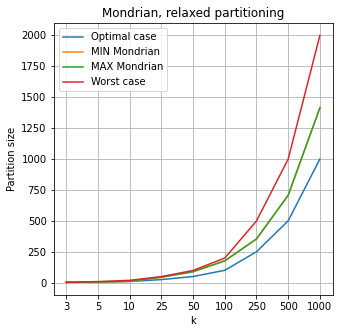

In [19]:
# check whether partition sizes are in the expected range
max_allowed_sizeR = [(2*k)-1 for k in ks]

ks = [3,5,10,25,50,100,250,500,1000]
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), ks, label='Optimal case')
plt.plot(np.arange(len(ks)), min_size_kR, label='MIN Mondrian')
plt.plot(np.arange(len(ks)), max_size_kR, label='MAX Mondrian')
plt.plot(np.arange(len(ks)), max_allowed_sizeR, label='Worst case')
plt.xticks(np.arange(len(ks)), labels=ks)
plt.xlabel('k')
plt.ylabel('Partition size')
plt.title('Mondrian, relaxed partitioning')
plt.legend()
plt.grid()
plt.show()

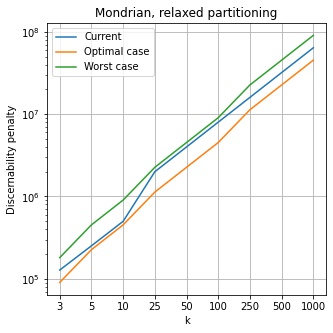

In [20]:
# plot discernability penalty evolution based on k values

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesR, label='Current')
plt.plot(np.arange(len(ks)), optimal_discR, label='Optimal case')
plt.plot(np.arange(len(ks)), worst_discR, label='Worst case')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7,1e8])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Mondrian, relaxed partitioning')
plt.legend()
plt.grid()
plt.show()

In [21]:
# strict mode

ks = [2,5,10,25,50,100,250,500,1000]
discernabilitiesS = []
execution_timesS = []
avg_metricsS = []
mean_size_kS = []
min_size_kS = []
max_size_kS = []
#quasi_identifiers = ['age','workclass','education','marital-status','occupation',
#         'race','sex','native-country']
quasi_identifiers_cols = ['age','workclass','education','marital-status','occupation','race','gender','native-country']
quasi_identifiers = {k: v for k, v in col_dict.items() if v in quasi_identifiers_cols}
sensitive_data_cols = ['income']
sensitive_data = {k: v for k, v in col_dict.items() if v in sensitive_data_cols}

for k in tqdm(ks):
  start = time.time()
  sizes = []
  equivalence_classes = partitioning(df, quasi_identifiers, k, cat_dict, 'strict')
  execution_timesS.append(time.time()-start)

  for i in range(len(equivalence_classes)):
    if len(equivalence_classes[i]) < k: # check partition sizes
      print('issue with k = {}, partition bounds were not respected'.format(k,i,len(equivalence_classes[i])))
    sizes.append(len(equivalence_classes[i]))
  mean_size_kS.append(np.sum(sizes)*1.0/len(equivalence_classes))
  max_size_kS.append(np.max(sizes))
  min_size_kS.append(np.min(sizes))
  
  discernabilitiesS.append(discernability(equivalence_classes))
  avg_metricsS.append(avg_eqclass(len(df),len(equivalence_classes),k))

100%|██████████| 9/9 [00:40<00:00,  4.46s/it]


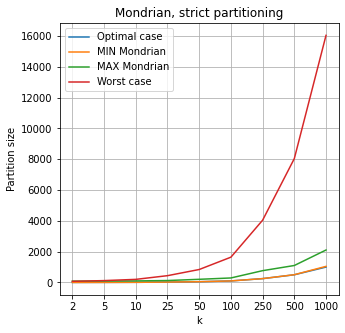

In [22]:
# check whether partition sizes are in the expected range
max_allowed_sizeS = [(2*len(quasi_identifiers)*(k-1))+m for k in ks]

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), ks, label='Optimal case')
plt.plot(np.arange(len(ks)), min_size_kS, label='MIN Mondrian')
plt.plot(np.arange(len(ks)), max_size_kS, label='MAX Mondrian')
plt.plot(np.arange(len(ks)), max_allowed_sizeS, label='Worst case')
plt.xticks(np.arange(len(ks)), labels=ks)
plt.xlabel('k')
plt.ylabel('Partition size')
plt.title('Mondrian, strict partitioning')
plt.legend()
plt.grid()
plt.show()

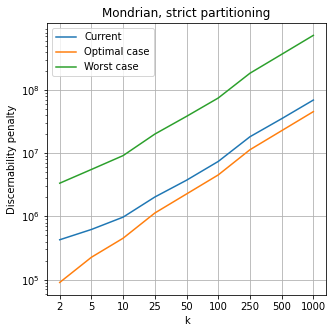

In [23]:
# check if discernability is between optimal and worse
optimal_discS = [k*len(df) for k in ks] # optimal
worst_discS = [] # worse
for k in ks:
  worst_discS.append((2*len(quasi_identifiers)*(k-1)+m)*len(df))

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesS, label='Current')
plt.plot(np.arange(len(ks)), optimal_discS, label='Optimal case')
plt.plot(np.arange(len(ks)), worst_discS, label='Worst case')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7,1e8])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Mondrian, strict partitioning')
plt.legend()
plt.grid()
plt.show()

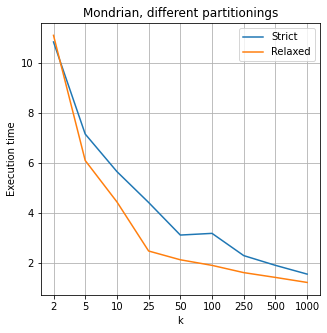

In [24]:
# plot execution time evolution based on k values

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), execution_timesS, label='Strict')
plt.plot(np.arange(len(ks)), execution_timesR, label='Relaxed')
plt.xticks(np.arange(len(ks)), labels=ks)
plt.xlabel('k')
plt.ylabel('Execution time')
plt.title('Mondrian, different partitionings')
plt.legend()
plt.grid()
plt.show()

### Test with synthetic data

In [25]:
from sklearn.preprocessing import KBinsDiscretizer

# generate 10 000 tuples with 5 attributes and per-attribute cardinality = 8
enc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='kmeans') # discretizer for normal distribution
n_tuples = 10000

# discrete uniform distribution
uniform = np.random.randint(low=0, high=8, size=(n_tuples,5))

# normal distribution (mean = 3.5, std = 0.2, k between 2 and 1000)
n1 = np.random.normal(loc=3.5, scale=0.2, size=(n_tuples,5))
normal1 = enc.fit(n1).transform(n1)

# normal distribution (mean = 3.5, std between 0.1 and 0.5, k = 10)
normal_std = []
stds = [0.1, 0.5, 1, 2, 5]
for std in stds:
  n2 = np.random.normal(loc=3.5, scale=std, size=(n_tuples,5))
  normal = enc.fit(n2).transform(n2)
  normal_std.append(normal)

# normal distribution (k = 10, std = 0.2, d between 2 and 8)
normal_d = []
dimensions = [2, 3, 4, 5, 6, 7, 8]
for d in dimensions:
  n3 = np.random.normal(loc=3.5, scale=0.2, size=(n_tuples,d))
  normal = enc.fit(n3).transform(n3)
  normal_d.append(normal)

100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


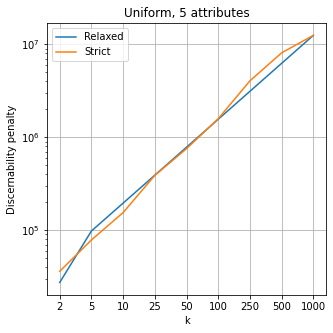

[27344.0, 97840.0, 195440.0, 390640.0, 781264.0, 1562512.0, 3125008.0, 6250000.0, 12500000.0] 
 [36058.0, 78402.0, 154516.0, 388646.0, 753428.0, 1582592.0, 4050416.0, 8106322.0, 12505496.0]


In [26]:
# uniform
ks = [2,5,10,25,50,100,250,500,1000]
discernabilitiesUR = []
discernabilitiesUS = []
cat = {} # no categorical variables

for k in tqdm(ks):
  equivalence_classesR = partitioning(uniform, np.arange(uniform.shape[1]), k, cat, 'relaxed')
  discernabilitiesUR.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(uniform, np.arange(uniform.shape[1]), k, cat, 'strict')
  discernabilitiesUS.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesUR, label='Relaxed')
plt.plot(np.arange(len(ks)), discernabilitiesUS, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Uniform, 5 attributes')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesUR,'\n',discernabilitiesUS)

100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


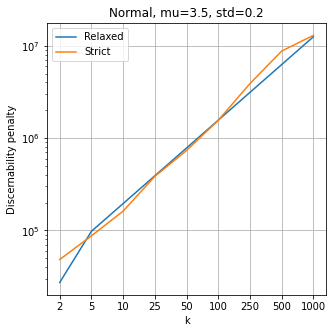

[27344.0, 97840.0, 195440.0, 390640.0, 781264.0, 1562512.0, 3125008.0, 6250000.0, 12500000.0] 
 [48400.0, 87384.0, 161852.0, 384478.0, 734736.0, 1557758.0, 3890098.0, 8754404.0, 12959220.0]


In [27]:
# normal distribution (mean = 3.5, std = 0.2, k between 2 and 1000)
ks = [2,5,10,25,50,100,250,500,1000]
discernabilitiesNR1 = []
discernabilitiesNS1 = []
cat = {} # no categorical variables

for k in tqdm(ks):
  equivalence_classesR = partitioning(normal1, np.arange(normal1.shape[1]), k, cat, 'relaxed')
  discernabilitiesNR1.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(normal1, np.arange(normal1.shape[1]), k, cat, 'strict')
  discernabilitiesNS1.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(ks)), discernabilitiesNR1, label='Relaxed')
plt.plot(np.arange(len(ks)), discernabilitiesNS1, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(ks)), labels=ks)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('k')
plt.ylabel('Discernability penalty')
plt.title('Normal, mu=3.5, std=0.2')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesNR1,'\n',discernabilitiesNS1)

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


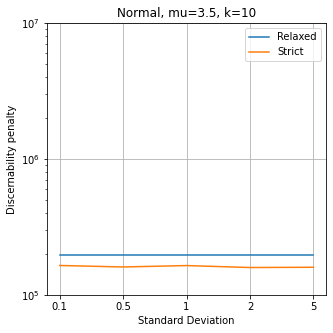

[195440.0, 195440.0, 195440.0, 195440.0, 195440.0] 
 [164332.0, 160240.0, 164080.0, 158740.0, 159478.0]


In [28]:
# normal distribution (mean = 3.5, std between 0.1 and 0.5, k = 10)
k = 10
discernabilitiesNR2 = []
discernabilitiesNS2 = []
cat = {} # no categorical variables

for n in tqdm(normal_std):
  equivalence_classesR = partitioning(n, np.arange(n.shape[1]), k, cat, 'relaxed')
  discernabilitiesNR2.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(n, np.arange(n.shape[1]), k, cat, 'strict')
  discernabilitiesNS2.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(stds)), discernabilitiesNR2, label='Relaxed')
plt.plot(np.arange(len(stds)), discernabilitiesNS2, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(stds)), labels=stds)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('Standard Deviation')
plt.ylabel('Discernability penalty')
plt.title('Normal, mu=3.5, k=10')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesNR2,'\n',discernabilitiesNS2)

100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


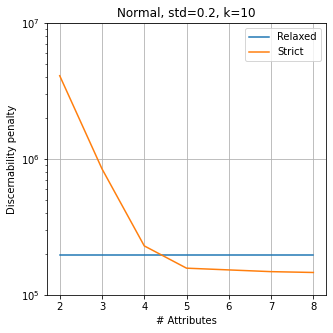

[195440.0, 195440.0, 195440.0, 195440.0, 195440.0, 195440.0, 195440.0] 
 [4093278.0, 845222.0, 229064.0, 157028.0, 152454.0, 148044.0, 145968.0]


In [29]:
# normal distribution (k = 10, std = 0.2, d between 2 and 8)
k = 10
discernabilitiesNR3 = []
discernabilitiesNS3 = []
cat = {} # no categorical variables

for n in tqdm(normal_d):
  equivalence_classesR = partitioning(n, np.arange(n.shape[1]), k, cat, 'relaxed')
  discernabilitiesNR3.append(discernability(equivalence_classesR))
  equivalence_classesS = partitioning(n, np.arange(n.shape[1]), k, cat, 'strict')
  discernabilitiesNS3.append(discernability(equivalence_classesS))
print('')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(len(dimensions)), discernabilitiesNR3, label='Relaxed')
plt.plot(np.arange(len(dimensions)), discernabilitiesNS3, label='Strict')
plt.yscale("log")
plt.xticks(np.arange(len(dimensions)), labels=dimensions)
plt.yticks([1e5,1e6,1e7])
plt.xlabel('# Attributes')
plt.ylabel('Discernability penalty')
plt.title('Normal, std=0.2, k=10')
plt.legend()
plt.grid()
plt.show()

print(discernabilitiesNR3,'\n',discernabilitiesNS3)

### Query workload

In [30]:
# 1000 tuples, with two quasi-identifier attributes (discrete normal, each with cardinality 50, μ = 25,σ = .2)
enc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='kmeans') # discretizer for normal distribution
n4 = np.random.normal(loc=25, scale=0.2, size=(1000,3))
normal4 = enc.fit(n4).transform(n4)
cat = {}

anonymised = []
ksq = [5,10,25,50]
for k in ksq:
  equivalence_classes = partitioning(normal4[:,:2], [0,1], k, cat, 'relaxed')
  dfn = anonymize_df(normal4, equivalence_classes, [0,1], [2], cat, mode='mean')
  anonymised.append(dfn)

128it [00:00, 15107.38it/s]
64it [00:00, 4720.57it/s]
32it [00:00, 5429.52it/s]
16it [00:00, 2246.55it/s]


In [31]:
# lhs/rhs queries
values = np.random.choice(np.arange(50), size=15, replace=False)
true_indices_1, true_indices_2 = [], []
est_indices_1, est_indices_2 = [], []

for v in values:
  # queries on first attribute
  true_1 = np.where(normal4[:,0] <= v)[0]
  true_indices_1.append(true_1)
  estimated = []
  for k in range(len(ksq)):
    est_k = np.where(anonymised[k][:,0] <= v)[0]
    estimated.append(est_k)
  est_indices_1.append(estimated)
  # queries on second attribute
  true_2 = np.where(normal4[:,1] <= v)[0]
  true_indices_2.append(true_2)
  estimated = []
  for k in range(len(ksq)):
    est_k = np.where(anonymised[k][:,1] <= v)[0]
    estimated.append(est_k)
  est_indices_2.append(estimated)

In [32]:
# results
accuracy_1, accuracy_2 = [], []
recall_1, recall_2 = [], []

for k in range(len(ksq)):
  
  acc_1_k, acc_2_k = [], []
  rec_1_k, rec_2_k = [], []
  
  for v in range(len(values)):

    expected_1 = len(true_indices_1[v])
    correct_1 = len([x for x in est_indices_1[v][k] if x in true_indices_1[v]])
    returned_1 = len(est_indices_1[v][k])
    if returned_1 != 0: acc_1_k.append(correct_1*1.0/returned_1)
    else: acc_1_k.append(0.0)
    if expected_1 != 0: rec_1_k.append(correct_1*1.0/expected_1)
    else: rec_1_k.append(0.0)

    expected_2 = len(true_indices_2[v])
    correct_2 = len([x for x in est_indices_2[v][k] if x in true_indices_2[v]])
    returned_2 = len(est_indices_2[v][k])
    if expected_2 != 0: acc_2_k.append(correct_2*1.0/expected_2)
    else: acc_2_k.append(0.0)
    if returned_2 != 0: rec_2_k.append(correct_2*1.0/returned_2)
    else: rec_2_k.append(0.0)
  
  accuracy_1.append(np.mean(acc_1_k))
  recall_1.append(np.mean(rec_1_k))
  accuracy_2.append(np.mean(acc_2_k))
  recall_2.append(np.mean(rec_2_k))

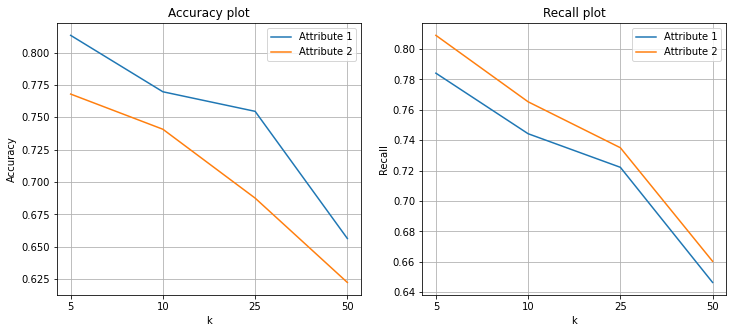

In [33]:
# plot

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(len(ksq)), accuracy_1, label='Attribute 1')
plt.plot(range(len(ksq)), accuracy_2, label='Attribute 2')
plt.xticks(range(len(ksq)), labels=ksq)
plt.title('Accuracy plot')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(range(len(ksq)), recall_1, label='Attribute 1')
plt.plot(range(len(ksq)), recall_2, label='Attribute 2')
plt.xticks(range(len(ksq)), labels=ksq)
plt.title('Recall plot')
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

In [34]:
# range queries
e = 3
true_indices_3, true_indices_4 = [], []
est_indices_3, est_indices_4 = [], []

for v in values:

  # queries on first attribute
  true_3 = np.where(np.logical_and(normal4[:,0]>=v-e, normal4[:,0]<=v+e))[0]
  true_indices_3.append(true_3)
  estimated = []
  for k in range(len(ksq)):
    est_k = np.where(np.logical_and(anonymised[k][:,0]>=v-e, anonymised[k][:,0]<=v+e))[0]
    estimated.append(est_k)
  est_indices_3.append(estimated)
  
  # queries on second attribute
  true_4 = np.where(np.logical_and(normal4[:,1]>=v-e, normal4[:,1]<=v+e))[0]
  true_indices_4.append(true_4)
  estimated = []
  for k in range(len(ksq)):
    est_k = np.where(np.logical_and(anonymised[k][:,1]>=v-e, anonymised[k][:,1]<=v+e))[0]
    estimated.append(est_k)
  est_indices_4.append(estimated)

In [35]:
# results
accuracy_3, accuracy_4 = [], []
recall_3, recall_4 = [], []

for k in range(len(ksq)):
  
  acc_3_k, acc_4_k = [], []
  rec_3_k, rec_4_k = [], []
  
  for v in range(len(values)):

    # results on first attribute
    expected_3 = len(true_indices_3[v])
    correct_3 = len([x for x in est_indices_3[v][k] if x in true_indices_3[v]])
    returned_3 = len(est_indices_3[v][k])
    if returned_3 != 0: acc_3_k.append(correct_3*1.0/returned_3)
    else: acc_3_k.append(0.0)
    if expected_3 != 0: rec_3_k.append(correct_3*1.0/expected_3)
    else: rec_3_k.append(0.0)

    # results on second attribute
    expected_4 = len(true_indices_4[v])
    correct_4 = len([x for x in est_indices_4[v][k] if x in true_indices_4[v]])
    returned_4 = len(est_indices_4[v][k])
    if expected_4 != 0: acc_4_k.append(correct_4*1.0/expected_4)
    else: acc_4_k.append(0.0)
    if returned_4 != 0: rec_4_k.append(correct_4*1.0/returned_4)
    else: rec_4_k.append(0.0)
  
  accuracy_3.append(np.mean(acc_3_k))
  recall_3.append(np.mean(rec_3_k))
  accuracy_4.append(np.mean(acc_4_k))
  recall_4.append(np.mean(rec_4_k))

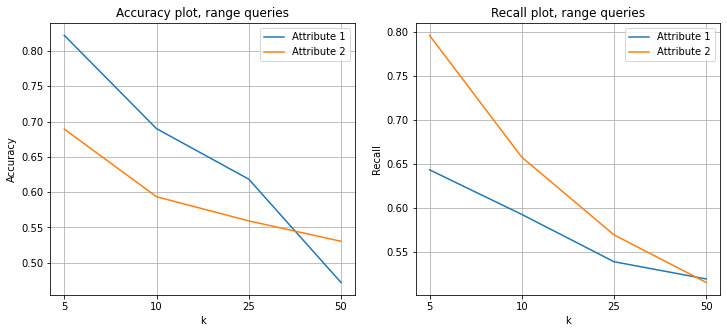

In [36]:
# plot

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(len(ksq)), accuracy_3, label='Attribute 1')
plt.plot(range(len(ksq)), accuracy_4, label='Attribute 2')
plt.xticks(range(len(ksq)), labels=ksq)
plt.title('Accuracy plot, range queries')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.plot(range(len(ksq)), recall_3, label='Attribute 1')
plt.plot(range(len(ksq)), recall_4, label='Attribute 2')
plt.xticks(range(len(ksq)), labels=ksq)
plt.title('Recall plot, range queries')
plt.xlabel('k')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()